In [1]:
import random
import os
from models import ImageModel

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import faiss
from scipy.spatial import procrustes
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp


In [2]:
dir: str = "/Volumes/Extreme SSD/wikiart/wikiart_5pct"
lo: int = 150
hi: int = 200


In [3]:
images: list[str] = []
metadata: list[str] = []
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith(".jpg") and file.startswith("image"):
            images.append(os.path.join(root, file))
        elif file.endswith(".json"):
            metadata.append(os.path.join(root, file))



In [4]:
def extract_contours(image: np.ndarray) -> list[np.ndarray]:
    """Extract contours from grayscale image"""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    canny_img = cv2.Canny(blurred, lo, hi)
    contours, _ = cv2.findContours(canny_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_squeezed = [c.squeeze() for c in contours if len(c) > 50]
    return contours_squeezed


def compute_enhanced_features(contour_points: np.ndarray) -> np.ndarray:
    """Compute enhanced feature vector: Hu moments + additional shape descriptors"""
    try:
        contour_points = contour_points.astype(np.float32)

        # 1. Hu moments (7 features)
        moments = cv2.moments(contour_points)
        if moments["m00"] == 0:
            return np.zeros(15, dtype=np.float32)  # Increased feature size

        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

        # 2. Additional shape features
        area = cv2.contourArea(contour_points)
        perimeter = cv2.arcLength(contour_points, closed=True)

        # Compactness (circularity)
        compactness = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Aspect ratio from bounding rectangle
        rect = cv2.minAreaRect(contour_points)
        width, height = rect[1]
        aspect_ratio = max(width, height) / (min(width, height) + 1e-10)

        # Extent (contour area / bounding rectangle area)
        x, y, w, h = cv2.boundingRect(contour_points)
        extent = area / (w * h) if (w * h) > 0 else 0

        # Solidity (contour area / convex hull area)
        hull = cv2.convexHull(contour_points)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0

        # Contour length (normalized)
        normalized_length = len(contour_points) / 1000.0  # Normalize by typical length

        # Combine all features
        additional_features = np.array(
            [
                compactness,
                aspect_ratio,
                extent,
                solidity,
                normalized_length,
                np.log10(area + 1),
                np.log10(perimeter + 1),
                np.log10(len(contour_points)),
            ],
            dtype=np.float32,
        )

        # Concatenate Hu moments + additional features
        enhanced_features = np.concatenate([hu_moments, additional_features])
        return enhanced_features

    except Exception as e:
        print(f"Error computing enhanced features: {e}")
        return np.zeros(15, dtype=np.float32)


def align_contours(sketch_pts, target_pts):
    """Align sketch_pts to target_pts using Procrustes"""
    N = min(len(sketch_pts), len(target_pts))
    sketch_resampled = sketch_pts[np.linspace(0, len(sketch_pts) - 1, N, dtype=int)]
    target_resampled = target_pts[np.linspace(0, len(target_pts) - 1, N, dtype=int)]
    mtx1, mtx2, disparity = procrustes(target_resampled, sketch_resampled)
    return mtx1, mtx2, disparity


def compute_procrustes_single(args):
    """Helper function for parallel Procrustes computation"""
    sketch_contour, hu_distance, img_path, contour_idx, contour_points = args
    try:
        _, _, procrustes_score = align_contours(sketch_contour, contour_points)
        return (procrustes_score, img_path, contour_idx, contour_points, hu_distance)
    except Exception:
        return None


def compute_procrustes_parallel(sketch_contour, faiss_results, n_workers=None):
    """Compute Procrustes scores in parallel"""
    if n_workers is None:
        n_workers = min(mp.cpu_count(), len(faiss_results))

    # Prepare arguments for parallel processing
    args_list = []
    for hu_distance, img_path, contour_idx, contour in faiss_results:
        args_list.append(
            (sketch_contour, hu_distance, img_path, contour_idx, contour.points)
        )

    # Process in parallel
    procrustes_results = []
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        # Submit all tasks
        future_to_args = {
            executor.submit(compute_procrustes_single, args): args for args in args_list
        }

        # Collect results with progress bar
        for future in tqdm(
            as_completed(future_to_args),
            total=len(args_list),
            desc="Computing Procrustes",
        ):
            result = future.result()
            if result is not None:
                procrustes_score, img_path, contour_idx, contour_points, hu_distance = (
                    result
                )
                # Reconstruct contour object for compatibility
                from models import Contour

                contour = Contour(
                    points=contour_points,
                    image_id=img_path,
                    image_shape=(100, 100),  # Dummy shape, won't be used
                )
                procrustes_results.append(
                    (procrustes_score, img_path, contour, hu_distance)
                )

    return procrustes_results



In [5]:
class ContourFAISSIndex:
    def __init__(self, use_weighted_distance=True):
        self.index = None
        self.contour_metadata = []  # List of (img_path, contour_idx, contour) tuples
        self.hu_features = []
        self.use_weighted_distance = use_weighted_distance

    def build_index(self, image_models: dict[str, ImageModel]):
        """Build FAISS index from all contours in image models"""
        print("Computing enhanced features for all contours...")

        feature_vectors = []
        metadata = []

        for img_path, img_model in tqdm(image_models.items()):
            for contour_idx, contour in enumerate(img_model.contours):
                enhanced_features = compute_enhanced_features(contour.points)

                # Skip invalid features
                if not np.any(np.isnan(enhanced_features)) and not np.any(
                    np.isinf(enhanced_features)
                ):
                    feature_vectors.append(enhanced_features)
                    metadata.append((img_path, contour_idx))

        if not feature_vectors:
            raise ValueError("No valid features computed")

        # Convert to numpy array
        self.hu_features = np.array(feature_vectors, dtype=np.float32)
        self.contour_metadata = metadata

        # Optionally normalize features for better FAISS performance
        if self.use_weighted_distance:
            # Normalize each feature dimension
            mean = np.mean(self.hu_features, axis=0)
            std = np.std(self.hu_features, axis=0) + 1e-8
            self.hu_features = (self.hu_features - mean) / std
            self.feature_mean = mean
            self.feature_std = std

        # Build FAISS index (L2 distance)
        dimension = len(feature_vectors[0])  # Enhanced features dimension
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(self.hu_features)

        print(
            f"Built FAISS index with {len(self.hu_features)} contours, {dimension}D features"
        )

    def search_similar_contours(self, sketch_contour: np.ndarray, k: int = 100):
        """Find k most similar contours using enhanced features"""
        if self.index is None:
            raise ValueError("Index not built yet")

        sketch_features = compute_enhanced_features(sketch_contour)
        if np.any(np.isnan(sketch_features)) or np.any(np.isinf(sketch_features)):
            print("Warning: Invalid features for sketch")
            return []

        # Apply same normalization as training data
        if self.use_weighted_distance:
            sketch_features = (sketch_features - self.feature_mean) / self.feature_std

        # Search FAISS index
        distances, indices = self.index.search(
            sketch_features.reshape(1, -1), k
        )  # Return metadata for found contours
        results = []
        for i, idx in enumerate(indices[0]):
            if idx < len(self.contour_metadata):
                img_path, contour_idx = self.contour_metadata[idx]
                results.append((distances[0][i], img_path, contour_idx))

        return results

    def save_index(self, filepath: str):
        """Save the FAISS index and metadata"""
        faiss.write_index(self.index, f"{filepath}.faiss")
        with open(f"{filepath}_metadata.pkl", "wb") as f:
            pickle.dump(
                {
                    "contour_metadata": self.contour_metadata,
                    "hu_features": self.hu_features,
                },
                f,
            )
        print(f"Saved index to {filepath}")

    def load_index(self, filepath: str):
        """Load the FAISS index and metadata"""
        self.index = faiss.read_index(f"{filepath}.faiss")
        with open(f"{filepath}_metadata.pkl", "rb") as f:
            data = pickle.load(f)
            self.contour_metadata = data["contour_metadata"]
            self.hu_features = data["hu_features"]
        print(f"Loaded index from {filepath}")



In [6]:
# Load and process images
print("Loading and processing images...")
image_ids: dict[str, ImageModel] = {}
random.seed(42)
# random_images = random.sample(images, k=min(500, len(images)))
random_images = images
print(random_images[-1])

for idx, img_path in tqdm(enumerate(random_images), total=len(random_images)):
    target_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if target_img is None:
        continue

    target_shape: tuple[int, int] = (target_img.shape[0], target_img.shape[1])
    target_contours: list[np.ndarray] = extract_contours(target_img)
    img_model: ImageModel = ImageModel(image_id=img_path, image_shape=target_shape)
    img_model.add_contours(target_contours)
    if img_model.contours:  # Only add if we found contours
        image_ids[img_path] = img_model

print(f"Processed {len(image_ids)} images")


Loading and processing images...
/Volumes/Extreme SSD/wikiart/wikiart_5pct/image_003999.jpg


100%|██████████| 4000/4000 [00:54<00:00, 73.01it/s] 

Processed 3753 images


In [7]:
# Build FAISS index
print("Building FAISS index...")
faiss_index = ContourFAISSIndex()
faiss_index.build_index(image_ids)

# Optionally save the index
faiss_index.save_index("contour_hu_index")
# faiss_index.load_index("contour_hu_index")


Building FAISS index...
Computing enhanced features for all contours...


100%|██████████| 3753/3753 [00:11<00:00, 330.25it/s]


Built FAISS index with 346757 contours, 15D features
Saved index to contour_hu_index


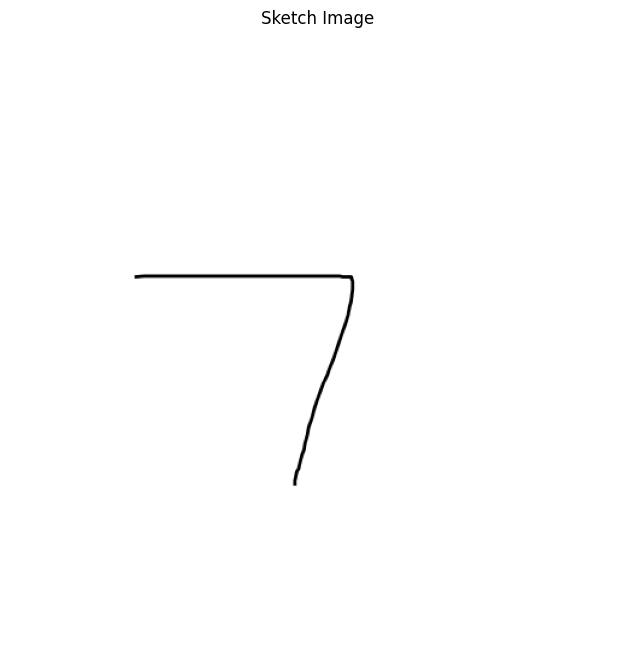

In [8]:
# Load sketch and extract contours
sketch_path = "../sketches/edge.png"
sketch_img = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
if sketch_img is None:
    raise ValueError("Failed to load sketch image")

plt.figure(figsize=(8, 8))
plt.imshow(sketch_img, cmap="gray")
plt.title("Sketch Image")
plt.axis("off")
plt.show()


In [9]:
# Extract sketch contours
sketch_model: ImageModel = ImageModel(
    image_id=sketch_path, image_shape=(sketch_img.shape[0], sketch_img.shape[1])
)
sketch_contours = extract_contours(sketch_img)
sketch_model.add_contours(sketch_contours)
print(f"Extracted {len(sketch_model.contours)} contours from sketch")



Extracted 1 contours from sketch


In [10]:
# Two-stage matching: FAISS + Procrustes
def find_best_matches(
    sketch_contour: np.ndarray,
    faiss_index: ContourFAISSIndex,
    top_k_faiss: int = 100,
    top_k_final: int = 5,
):
    """
    Two-stage matching:
    1. Use FAISS to find top_k_faiss candidates based on Hu moments
    2. Use Procrustes to refine and get top_k_final results
    """
    print(f"Stage 1: FAISS search for top {top_k_faiss} candidates...")
    faiss_results = faiss_index.search_similar_contours(sketch_contour, k=top_k_faiss)

    if not faiss_results:
        print("No FAISS results found")
        return []

    print(f"Stage 2: Procrustes refinement on {len(faiss_results)} candidates...")
    procrustes_results = []

    for hu_distance, img_path, contour_idx in tqdm(faiss_results):
        contour = image_ids[img_path].contours[contour_idx]
        try:
            _, _, procrustes_score = align_contours(sketch_contour, contour.points)
            procrustes_results.append(
                (procrustes_score, img_path, contour, hu_distance)
            )
        except Exception:
            continue

    # Sort by Procrustes score (lower is better)
    procrustes_results.sort(key=lambda x: x[0])
    return procrustes_results[:top_k_final]



Running two-stage matching...
Stage 1: FAISS search for top 40000 candidates...
Stage 2: Procrustes refinement on 40000 candidates...


100%|██████████| 40000/40000 [00:02<00:00, 16210.90it/s]


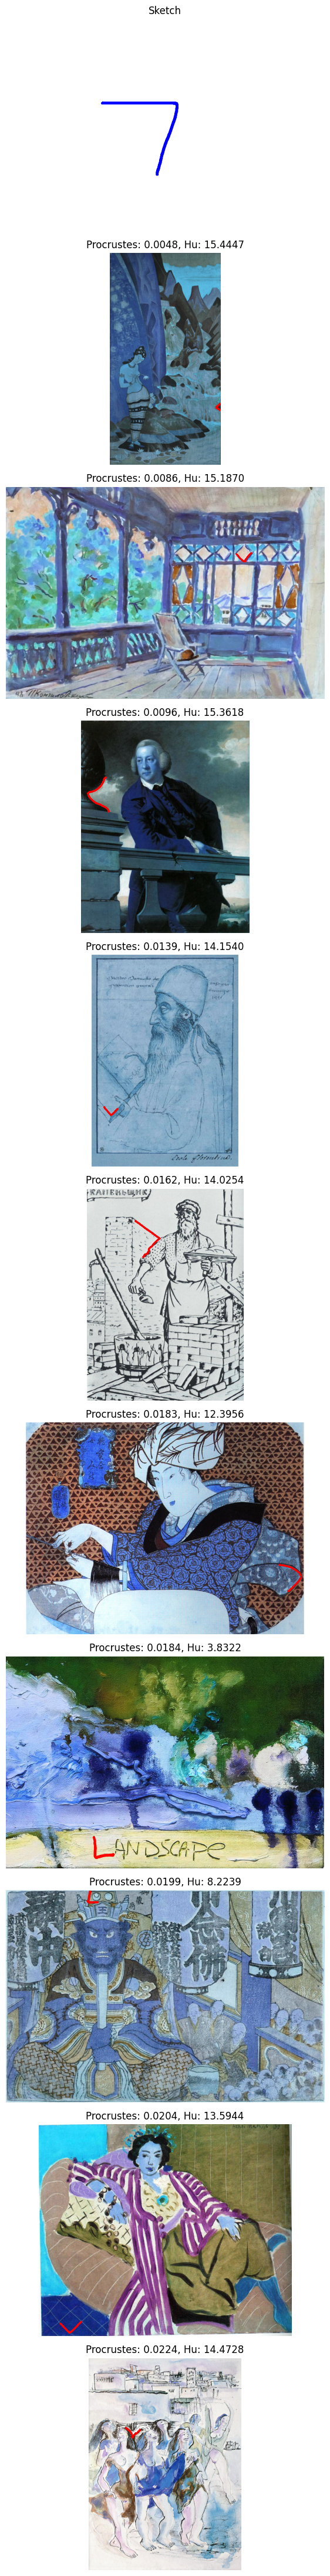


Top matches:
1. Procrustes score: 0.0048, Hu distance: 15.4447
   Image: image_003484.jpg
2. Procrustes score: 0.0086, Hu distance: 15.1870
   Image: image_000383.jpg
3. Procrustes score: 0.0096, Hu distance: 15.3618
   Image: image_002210.jpg
4. Procrustes score: 0.0139, Hu distance: 14.1540
   Image: image_003191.jpg
5. Procrustes score: 0.0162, Hu distance: 14.0254
   Image: image_000846.jpg
6. Procrustes score: 0.0183, Hu distance: 12.3956
   Image: image_001488.jpg
7. Procrustes score: 0.0184, Hu distance: 3.8322
   Image: image_003343.jpg
8. Procrustes score: 0.0199, Hu distance: 8.2239
   Image: image_001184.jpg
9. Procrustes score: 0.0204, Hu distance: 13.5944
   Image: image_001687.jpg
10. Procrustes score: 0.0224, Hu distance: 14.4728
   Image: image_003959.jpg


In [11]:
# Run matching for the first sketch contour
if sketch_model.contours:
    sketch_contour = sketch_model.contours[0].points

    print("Running two-stage matching...")
    best_matches = find_best_matches(
        sketch_contour, faiss_index, top_k_faiss=40_000, top_k_final=10
    )

    # Visualize results
    n_results = len(best_matches)
    if n_results > 0:
        fig, ax = plt.subplots(n_results + 1, 1, figsize=(8, 4 * (n_results + 1)))

        # Show sketch
        ax[0].imshow(sketch_img, cmap="gray")
        sketch_pts = np.array(sketch_contour, dtype=np.int32)
        ax[0].plot(sketch_pts[:, 0], sketch_pts[:, 1], color="blue", linewidth=2)
        ax[0].set_title("Sketch")
        ax[0].axis("off")

        # Show matches
        for i, (procrustes_score, img_path, contour, hu_distance) in enumerate(
            best_matches
        ):
            target_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if target_img is not None:
                ax[i + 1].imshow(target_img)
                pts = np.array(contour.points, dtype=np.int32)
                ax[i + 1].plot(pts[:, 0], pts[:, 1], color="red", linewidth=2)
                ax[i + 1].set_title(
                    f"Procrustes: {procrustes_score:.4f}, Hu: {hu_distance:.4f}"
                )
                ax[i + 1].axis("off")

        plt.tight_layout()
        plt.show()

        print("\nTop matches:")
        for i, (procrustes_score, img_path, contour, hu_distance) in enumerate(
            best_matches
        ):
            print(
                f"{i + 1}. Procrustes score: {procrustes_score:.4f}, Hu distance: {hu_distance:.4f}"
            )
            print(f"   Image: {os.path.basename(img_path)}")
    else:
        print("No matches found")
else:
    print("No contours found in sketch")
